# DLITE vs. Cross Entropy for Tinyshakespeare
10/11/2023

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    # Define the loss functions
    ce_loss_func = nn.CrossEntropyLoss()
    l1_loss_func = nn.L1Loss()
    l2_loss_func = nn.MSELoss()  # This is the L2 loss

    # Prepare dictionaries to store the output losses
    dlite_out = {}
    ce_out = {}
    l1_out = {}
    l2_out = {}

    model.eval()  # Set the model to evaluation mode
    for split in ['train', 'val']:
        dlite_losses = torch.zeros(eval_iters)
        ce_losses = torch.zeros(eval_iters)
        l1_losses = torch.zeros(eval_iters)
        l2_losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, _ = model(X, Y)

            # Reshape the logits
            logits_flat = logits.view(-1, logits.size(-1))  # Flattening the logits

            # Convert targets to one-hot encoding
            targets_flat = Y.view(-1)
            targets_one_hot = F.one_hot(targets_flat, num_classes=logits.size(-1)).float()


            # Calculate the losses
            dlite_losses[k] = dlite_loss(logits_flat, targets_flat).item()
            ce_losses[k] = ce_loss_func(logits_flat, targets_flat).item()  # Assuming vocab_size is the same as logits.size(-1)
            l1_losses[k] = l1_loss_func(logits_flat, targets_one_hot).item()
            l2_losses[k] = l2_loss_func(logits_flat, targets_one_hot).item()

        # Store the mean loss for each metric
        dlite_out[split] = dlite_losses.mean().item()
        ce_out[split] = ce_losses.mean().item()
        l1_out[split] = l1_losses.mean().item()
        l2_out[split] = l2_losses.mean().item()

    model.train()  # Set the model back to training mode
    return dlite_out, ce_out, l1_out, l2_out

def one_hot_encode(targets, num_classes):
    """
    One-hot encode a tensor of class indices.

    Arguments:
    - targets (torch.Tensor): A tensor of class indices, shape [N].
    - num_classes (int): The number of classes.

    Returns:
    - torch.Tensor: The one-hot encoded tensor, shape [N, num_classes].
    """
    return F.one_hot(targets, num_classes=num_classes).float()



class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# DLITE Loss function
class DLITELoss(nn.Module):
    def __init__(self):
        super(DLITELoss, self).__init__()

    def forward(self, logits, targets, epsilon=1e-10):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=-1)

        # One-hot encode the targets to get true probabilities
        true_probs = F.one_hot(targets, num_classes=probs.size(-1)).float()

        # Define the g function
        g_values = torch.abs(probs * (1 - torch.log(probs + epsilon)) - true_probs * (1 - torch.log(true_probs + epsilon)))

        # Define the delta_h function
        delta_h_values = torch.abs(probs**2 * (1 - 2 * torch.log(probs + epsilon)) - true_probs**2 * (1 - 2 * torch.log(true_probs + epsilon))) / (2 * (probs + true_probs))

        # Compute DLITE loss for each class
        dl_values = g_values - delta_h_values

        # Sum over all classes and average over batch size
        loss = dl_values.sum(dim=-1).mean()

        return loss

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.loss_func = DLITELoss()  # Initialize the DLITE loss function

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = self.loss_func(logits, targets)  # Use DLITE loss here

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



--2023-10-13 17:54:15--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-10-13 17:54:15 (17.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



## Baseline training using DLITE

0.209729 M parameters
step 0: DLITE train loss 0.9281, DLITE val loss 0.9275, CE train loss: 4.4116, CE val loss 4.4022, L1 train loss: 0.4805, L1 val loss 0.4806, L2 train loss: 0.3639, L2 val loss 0.3641

step 100: DLITE train loss 0.6724, DLITE val loss 0.6736, CE train loss: 3.3284, CE val loss 3.4019, L1 train loss: 2.0532, L1 val loss 2.0447, L2 train loss: 5.1945, L2 val loss 5.1683

step 200: DLITE train loss 0.6473, DLITE val loss 0.6496, CE train loss: 3.3351, CE val loss 3.4165, L1 train loss: 2.3862, L1 val loss 2.3683, L2 train loss: 7.0650, L2 val loss 6.9947

step 300: DLITE train loss 0.6313, DLITE val loss 0.6368, CE train loss: 3.3308, CE val loss 3.4452, L1 train loss: 2.5618, L1 val loss 2.5419, L2 train loss: 8.1944, L2 val loss 8.1069

step 400: DLITE train loss 0.6191, DLITE val loss 0.6233, CE train loss: 3.2563, CE val loss 3.3515, L1 train loss: 2.7072, L1 val loss 2.6824, L2 train loss: 9.0917, L2 val loss 8.9671

step 500: DLITE train loss 0.6065, DLITE val 

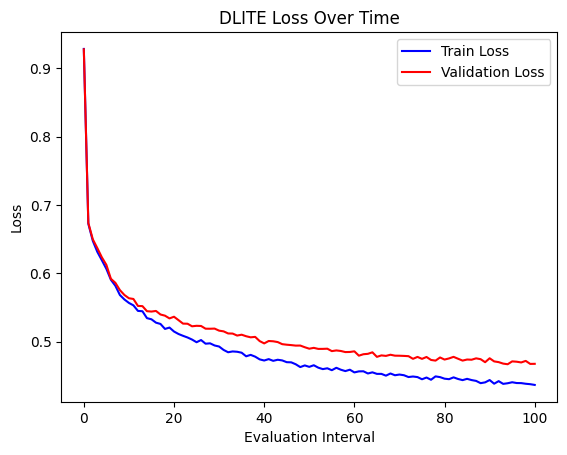

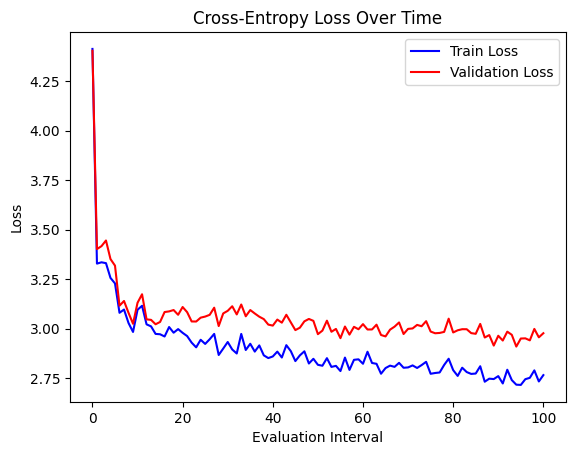

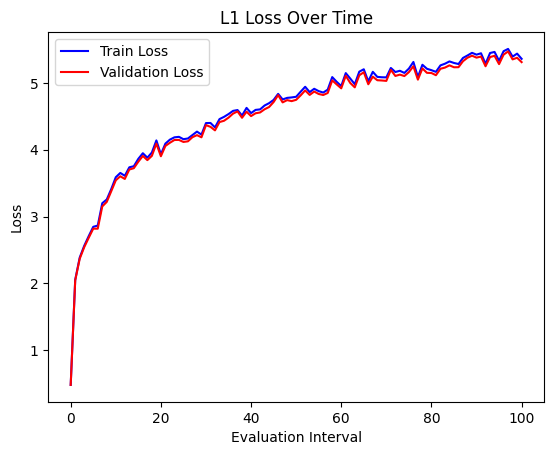

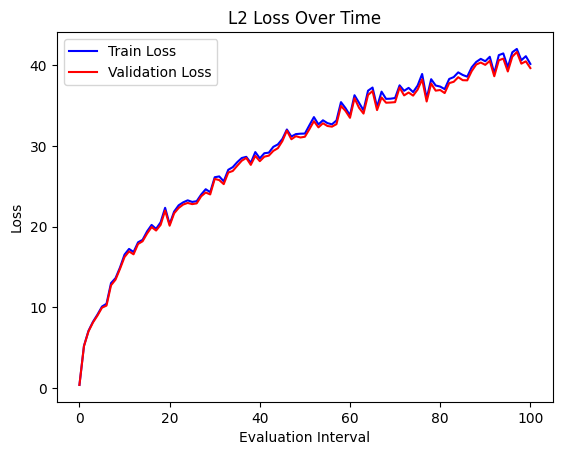

In [21]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


l1_loss_fn = nn.L1Loss()
l2_loss_fn = nn.MSELoss()


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()

# Lists to store the loss values
train_losses_dlite = []
val_losses_dlite = []
ce_train_losses_dlite = []
ce_val_losses_dlite = []

# Lists to store additional loss values
l1_train_losses_dlite = []
l1_val_losses_dlite = []
l2_train_losses_dlite = []
l2_val_losses_dlite = []


for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, l1_losses, l2_losses = estimate_loss()  # modify estimate_loss to return L1 and L2 losses
        print(f"step {iter}: DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}, CE train loss: {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}, L1 train loss: {l1_losses['train']:.4f}, L1 val loss {l1_losses['val']:.4f}, L2 train loss: {l2_losses['train']:.4f}, L2 val loss {l2_losses['val']:.4f}\n")

        # Append the losses for this iteration
        train_losses_dlite.append(dlite_losses['train'])
        val_losses_dlite.append(dlite_losses['val'])
        ce_train_losses_dlite.append(ce_losses['train'])
        ce_val_losses_dlite.append(ce_losses['val'])
        l1_train_losses_dlite.append(l1_losses['train'])
        l1_val_losses_dlite.append(l1_losses['val'])
        l2_train_losses_dlite.append(l2_losses['train'])
        l2_val_losses_dlite.append(l2_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # One-hot encode the targets to match the shape of the logits
    targets_one_hot = one_hot_encode(targets_flat, num_classes=logits_flat.size(-1))  # logits_flat.size(-1) should be your vocab_size

    # Calculate L1 and L2 loss
    l1_loss = l1_loss_fn(logits_flat, targets_one_hot)
    l2_loss = l2_loss_fn(logits_flat, targets_one_hot)


    # Compute the DLITE loss using the flattened logits and targets
    loss = dlite_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


!pip install matplotlib
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Convert evaluation interval steps to actual iterations
eval_points = [i * eval_interval for i in range(len(train_losses_dlite))]

# Plotting DLITE Loss
plot_losses(train_losses_dlite, val_losses_dlite, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses_dlite, ce_val_losses_dlite, 'Cross-Entropy Loss Over Time')

# Plotting L1 Loss
plot_losses(l1_train_losses_dlite, l1_val_losses_dlite, 'L1 Loss Over Time')

# Plotting L2 Loss
plot_losses(l2_train_losses_dlite, l2_val_losses_dlite, 'L2 Loss Over Time')


## Baseline training using Cross Entropy

0.209729 M parameters
step 0: DLITE train loss 0.9281, DLITE val loss 0.9275, CE train loss: 4.4116, CE val loss 4.4022, L1 train loss: 0.4805, L1 val loss 0.4806, L2 train loss: 0.3639, L2 val loss 0.3641

step 100: DLITE train loss 0.6977, DLITE val loss 0.6981, CE train loss: 2.6568, CE val loss 2.6670, L1 train loss: 1.4350, L1 val loss 1.4141, L2 train loss: 2.7604, L2 val loss 2.6987

step 200: DLITE train loss 0.6712, DLITE val loss 0.6701, CE train loss: 2.5091, CE val loss 2.5059, L1 train loss: 1.8044, L1 val loss 1.7782, L2 train loss: 4.3092, L2 val loss 4.2116

step 300: DLITE train loss 0.6490, DLITE val loss 0.6505, CE train loss: 2.4194, CE val loss 2.4335, L1 train loss: 1.9703, L1 val loss 1.9453, L2 train loss: 5.1889, L2 val loss 5.0858

step 400: DLITE train loss 0.6343, DLITE val loss 0.6347, CE train loss: 2.3500, CE val loss 2.3564, L1 train loss: 2.0905, L1 val loss 2.0670, L2 train loss: 5.9121, L2 val loss 5.8046

step 500: DLITE train loss 0.6188, DLITE val 

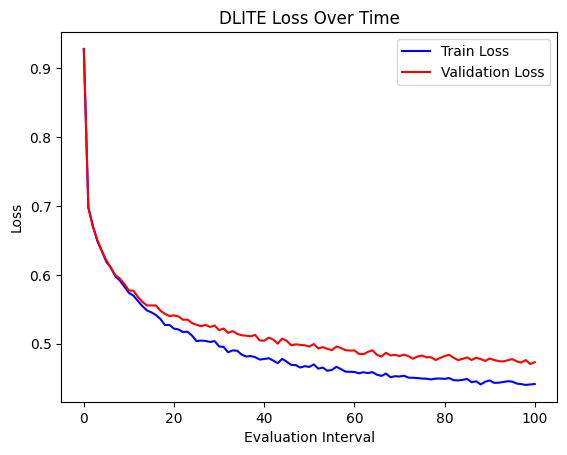

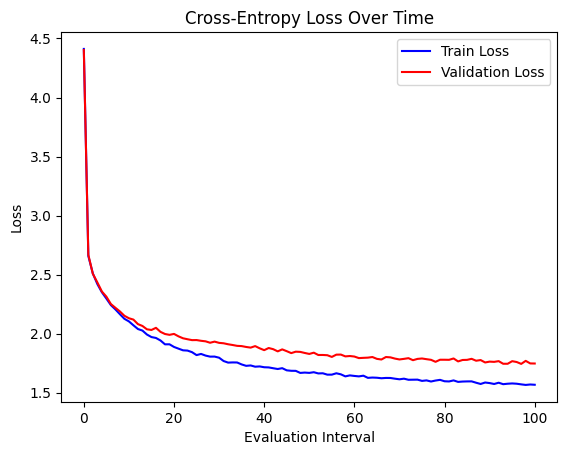

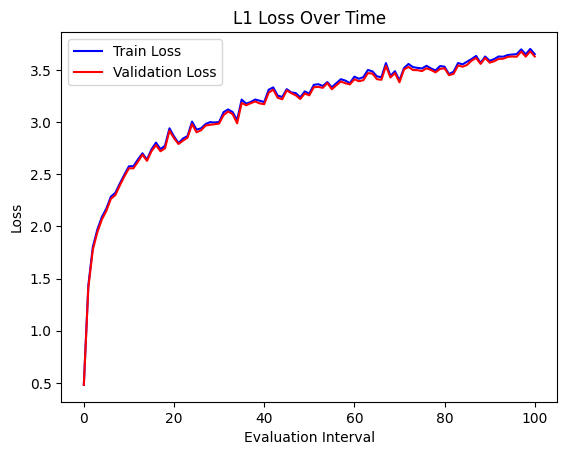

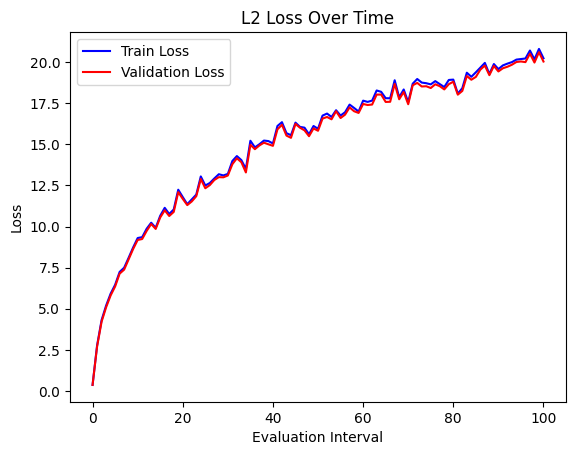

In [24]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(1337)


model = BigramLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')



l1_loss_fn = nn.L1Loss()
l2_loss_fn = nn.MSELoss()


# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()  # Cross-Entropy loss

# Lists to store the loss values
train_losses_ce = []
val_losses_ce = []
ce_train_losses_ce = []  # Cross-Entropy train losses
ce_val_losses_ce = []    # Cross-Entropy validation losses


# Lists to store additional loss values
l1_train_losses_ce = []
l1_val_losses_ce = []
l2_train_losses_ce = []
l2_val_losses_ce = []

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, l1_losses, l2_losses = estimate_loss()  # modify estimate_loss to return L1 and L2 losses
        print(f"step {iter}: DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}, CE train loss: {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}, L1 train loss: {l1_losses['train']:.4f}, L1 val loss {l1_losses['val']:.4f}, L2 train loss: {l2_losses['train']:.4f}, L2 val loss {l2_losses['val']:.4f}\n")

        # Append the losses for this iteration
        train_losses_ce.append(dlite_losses['train'])
        val_losses_ce.append(dlite_losses['val'])
        ce_train_losses_ce.append(ce_losses['train'])
        ce_val_losses_ce.append(ce_losses['val'])
        l1_train_losses_ce.append(l1_losses['train'])
        l1_val_losses_ce.append(l1_losses['val'])
        l2_train_losses_ce.append(l2_losses['train'])
        l2_val_losses_ce.append(l2_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # One-hot encode the targets to match the shape of the logits
    targets_one_hot = one_hot_encode(targets_flat, num_classes=logits_flat.size(-1))  # logits_flat.size(-1) should be your vocab_size

    # Calculate L1 and L2 loss
    l1_loss = l1_loss_fn(logits_flat, targets_one_hot)
    l2_loss = l2_loss_fn(logits_flat, targets_one_hot)

    # Compute the DLITE loss using the flattened logits and targets
    loss = ce_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Convert evaluation interval steps to actual iterations
eval_points = [i * eval_interval for i in range(len(train_losses_dlite))]

# Plotting DLITE Loss
plot_losses(train_losses_ce, val_losses_ce, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses_ce, ce_val_losses_ce, 'Cross-Entropy Loss Over Time')

# Plotting L1 Loss
plot_losses(l1_train_losses_ce, l1_val_losses_ce, 'L1 Loss Over Time')

# Plotting L2 Loss
plot_losses(l2_train_losses_ce, l2_val_losses_ce, 'L2 Loss Over Time')



0.209729 M parameters
step 0: DLITE train loss 0.9281, DLITE val loss 0.9275, CE train loss: 4.4116, CE val loss 4.4022, L1 train loss: 0.4805, L1 val loss 0.4806, L2 train loss: 0.3639, L2 val loss 0.3641

step 100: DLITE train loss 0.6724, DLITE val loss 0.6736, CE train loss: 3.3284, CE val loss 3.4019, L1 train loss: 2.0532, L1 val loss 2.0447, L2 train loss: 5.1945, L2 val loss 5.1683

step 200: DLITE train loss 0.6473, DLITE val loss 0.6496, CE train loss: 3.3351, CE val loss 3.4165, L1 train loss: 2.3862, L1 val loss 2.3683, L2 train loss: 7.0650, L2 val loss 6.9947

step 300: DLITE train loss 0.6313, DLITE val loss 0.6368, CE train loss: 3.3308, CE val loss 3.4452, L1 train loss: 2.5618, L1 val loss 2.5419, L2 train loss: 8.1944, L2 val loss 8.1069

step 400: DLITE train loss 0.6191, DLITE val loss 0.6233, CE train loss: 3.2563, CE val loss 3.3515, L1 train loss: 2.7072, L1 val loss 2.6824, L2 train loss: 9.0917, L2 val loss 8.9671

step 500: DLITE train loss 0.6065, DLITE val 

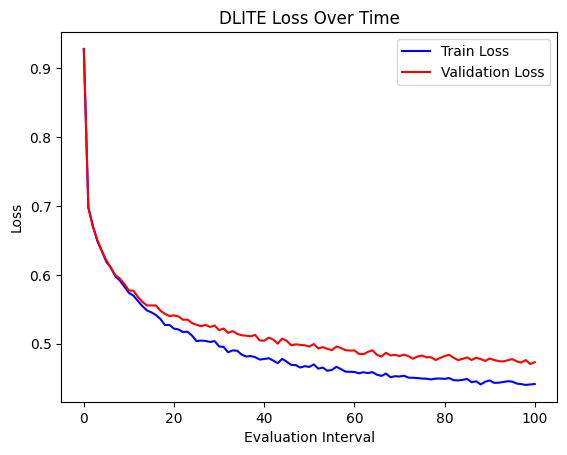

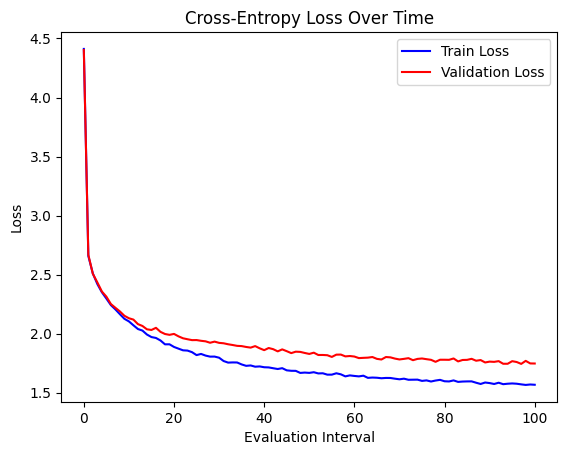

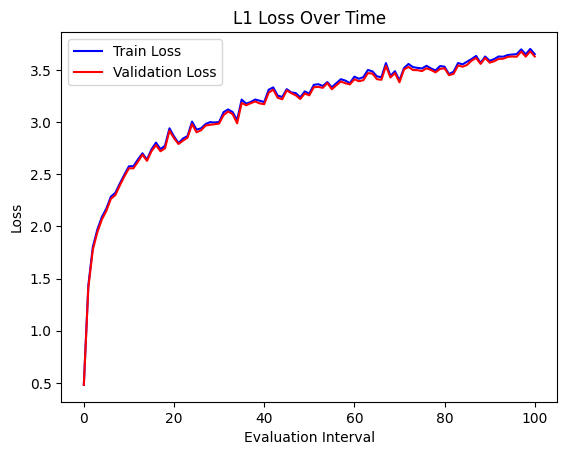

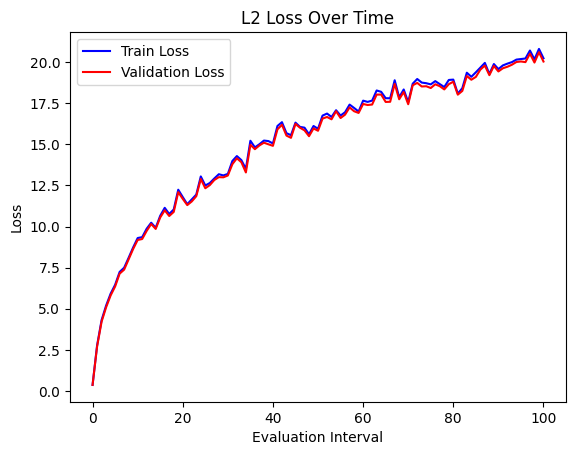

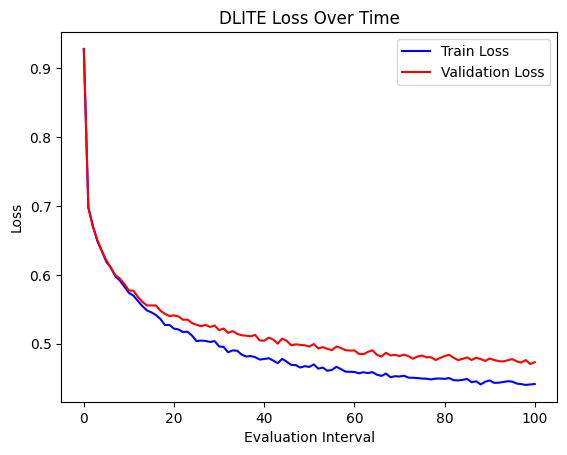

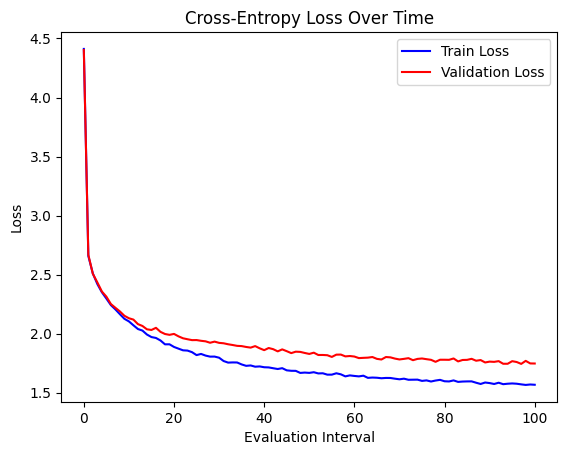

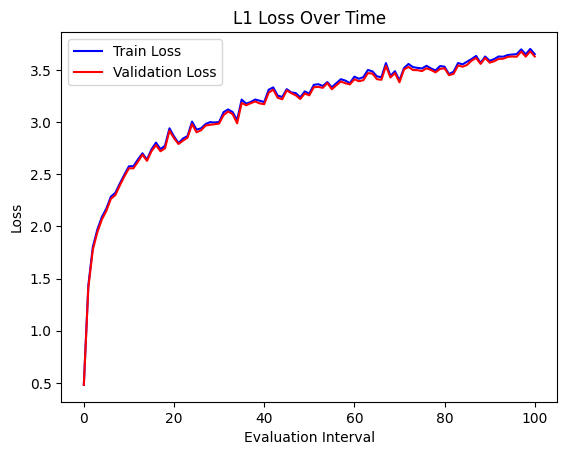

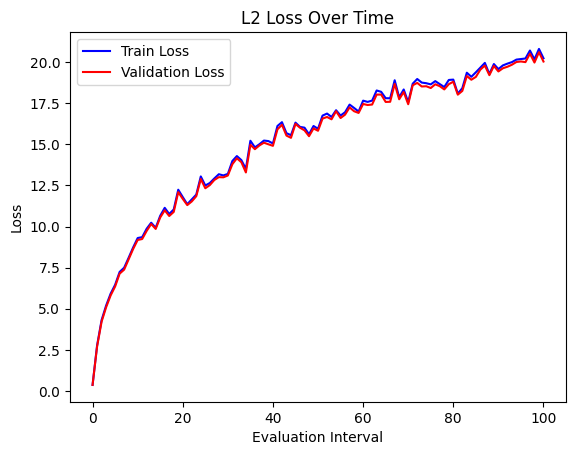

In [27]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(1337)


model = BigramLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')



l1_loss_fn = nn.L1Loss()
l2_loss_fn = nn.MSELoss()


# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()  # Cross-Entropy loss

# Lists to store the loss values
train_losses_mix = []
val_losses_mix = []
ce_train_losses_mix = []  # Cross-Entropy train losses
ce_val_losses_mix = []    # Cross-Entropy validation losses


# Lists to store additional loss values
l1_train_losses_mix = []
l1_val_losses_mix = []
l2_train_losses_mix = []
l2_val_losses_mix = []



# first train with dlite



for iter in range(int(max_iters / 2)):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, l1_losses, l2_losses = estimate_loss()  # modify estimate_loss to return L1 and L2 losses
        print(f"step {iter}: DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}, CE train loss: {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}, L1 train loss: {l1_losses['train']:.4f}, L1 val loss {l1_losses['val']:.4f}, L2 train loss: {l2_losses['train']:.4f}, L2 val loss {l2_losses['val']:.4f}\n")

        # Append the losses for this iteration
        train_losses_mix.append(dlite_losses['train'])
        val_losses_mix.append(dlite_losses['val'])
        ce_train_losses_mix.append(ce_losses['train'])
        ce_val_losses_mix.append(ce_losses['val'])
        l1_train_losses_mix.append(l1_losses['train'])
        l1_val_losses_mix.append(l1_losses['val'])
        l2_train_losses_mix.append(l2_losses['train'])
        l2_val_losses_mix.append(l2_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # One-hot encode the targets to match the shape of the logits
    targets_one_hot = one_hot_encode(targets_flat, num_classes=logits_flat.size(-1))  # logits_flat.size(-1) should be your vocab_size

    # Calculate L1 and L2 loss
    l1_loss = l1_loss_fn(logits_flat, targets_one_hot)
    l2_loss = l2_loss_fn(logits_flat, targets_one_hot)

    # Compute the DLITE loss using the flattened logits and targets
    loss = dlite_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



# then train with CE



for iter in range(int(max_iters / 2), max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, l1_losses, l2_losses = estimate_loss()  # modify estimate_loss to return L1 and L2 losses
        print(f"step {iter}: DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}, CE train loss: {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}, L1 train loss: {l1_losses['train']:.4f}, L1 val loss {l1_losses['val']:.4f}, L2 train loss: {l2_losses['train']:.4f}, L2 val loss {l2_losses['val']:.4f}\n")

        # Append the losses for this iteration
        train_losses_mix.append(dlite_losses['train'])
        val_losses_mix.append(dlite_losses['val'])
        ce_train_losses_mix.append(ce_losses['train'])
        ce_val_losses_mix.append(ce_losses['val'])
        l1_train_losses_mix.append(l1_losses['train'])
        l1_val_losses_mix.append(l1_losses['val'])
        l2_train_losses_mix.append(l2_losses['train'])
        l2_val_losses_mix.append(l2_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # One-hot encode the targets to match the shape of the logits
    targets_one_hot = one_hot_encode(targets_flat, num_classes=logits_flat.size(-1))  # logits_flat.size(-1) should be your vocab_size

    # Calculate L1 and L2 loss
    l1_loss = l1_loss_fn(logits_flat, targets_one_hot)
    l2_loss = l2_loss_fn(logits_flat, targets_one_hot)

    # Compute the DLITE loss using the flattened logits and targets
    loss = ce_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Convert evaluation interval steps to actual iterations
eval_points = [i * eval_interval for i in range(len(train_losses_dlite))]

# Plotting DLITE Loss
plot_losses(train_losses_ce, val_losses_ce, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses_ce, ce_val_losses_ce, 'Cross-Entropy Loss Over Time')

# Plotting L1 Loss
plot_losses(l1_train_losses_ce, l1_val_losses_ce, 'L1 Loss Over Time')

# Plotting L2 Loss
plot_losses(l2_train_losses_ce, l2_val_losses_ce, 'L2 Loss Over Time')



def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Convert evaluation interval steps to actual iterations
eval_points = [i * eval_interval for i in range(len(train_losses_dlite))]

# Plotting DLITE Loss
plot_losses(train_losses_ce, val_losses_ce, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses_ce, ce_val_losses_ce, 'Cross-Entropy Loss Over Time')

# Plotting L1 Loss
plot_losses(l1_train_losses_ce, l1_val_losses_ce, 'L1 Loss Over Time')

# Plotting L2 Loss
plot_losses(l2_train_losses_ce, l2_val_losses_ce, 'L2 Loss Over Time')
